This notebook desined for tabular classification tasks with pandas and scikit-learn.
It is a simple example of how to use pandas and scikit-learn to build a classification model using a tabular dataset. The code includes data preprocessing, model training, and evaluation steps.
The dataset used in this example is the bank marketing dataset from the UCI Machine Learning Repository. The dataset contains information about a bank's marketing campaign and whether or not a customer subscribed to a term deposit.
The goal is to predict whether a customer will subscribe to a term deposit based on their demographic and behavioral features.


In [1]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



Matplotlib is building the font cache; this may take a moment.


In [19]:
data=pd.read_csv('/home/tisinr/MEGA/Dev/models/classifier/dataset/bank.csv',header=0, sep=';')
# Display the first few rows of the dataset
print(data.head(15))

    age           job   marital  education default  balance housing loan  \
0    58    management   married   tertiary      no     2143     yes   no   
1    44    technician    single  secondary      no       29     yes   no   
2    33  entrepreneur   married  secondary      no        2     yes  yes   
3    47   blue-collar   married    unknown      no     1506     yes   no   
4    33       unknown    single    unknown      no        1      no   no   
5    35    management   married   tertiary      no      231     yes   no   
6    28    management    single   tertiary      no      447     yes  yes   
7    42  entrepreneur  divorced   tertiary     yes        2     yes   no   
8    58       retired   married    primary      no      121     yes   no   
9    43    technician    single  secondary      no      593     yes   no   
10   41        admin.  divorced  secondary      no      270     yes   no   
11   29        admin.    single  secondary      no      390     yes   no   
12   53    t

In [20]:
#Rename some columns
data.rename(columns={'marital':'marital_status','default':'credit_default','housing':'housing_loan','loan':'personal_loan','y':'target'}, inplace=True)

#change data types
data['target'] = data['target'].astype('category')
data['marital_status'] = data['marital_status'].astype('category')
data['education'] = data['education'].astype('category')
data['job'] = data['job'].astype('category')
data['contact'] = data['contact'].astype('category')
data['month'] = data['month'].astype('category')
data['day'] = data['day'].astype('category')
data['credit_default'] = data['credit_default'].astype('category')
data['housing_loan'] = data['housing_loan'].astype('category')
data['personal_loan'] = data['personal_loan'].astype('category')

In [22]:
data.replace('unknown', pd.NA, inplace=True)

In [24]:
data.isnull().sum()

age                   0
job                 288
marital_status        0
education          1857
credit_default        0
balance               0
housing_loan          0
personal_loan         0
contact           13020
day                   0
month                 0
duration              0
campaign              0
pdays                 0
previous              0
poutcome          36959
target                0
dtype: int64

Exploratory Data Analysis with Pandas

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45211 non-null  int64   
 1   job             44923 non-null  category
 2   marital_status  45211 non-null  category
 3   education       43354 non-null  category
 4   credit_default  45211 non-null  category
 5   balance         45211 non-null  int64   
 6   housing_loan    45211 non-null  category
 7   personal_loan   45211 non-null  category
 8   contact         32191 non-null  category
 9   day             45211 non-null  category
 10  month           45211 non-null  category
 11  duration        45211 non-null  int64   
 12  campaign        45211 non-null  int64   
 13  pdays           45211 non-null  int64   
 14  previous        45211 non-null  int64   
 15  poutcome        8252 non-null   object  
 16  target          45211 non-null  category
dtypes: category(

In [7]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


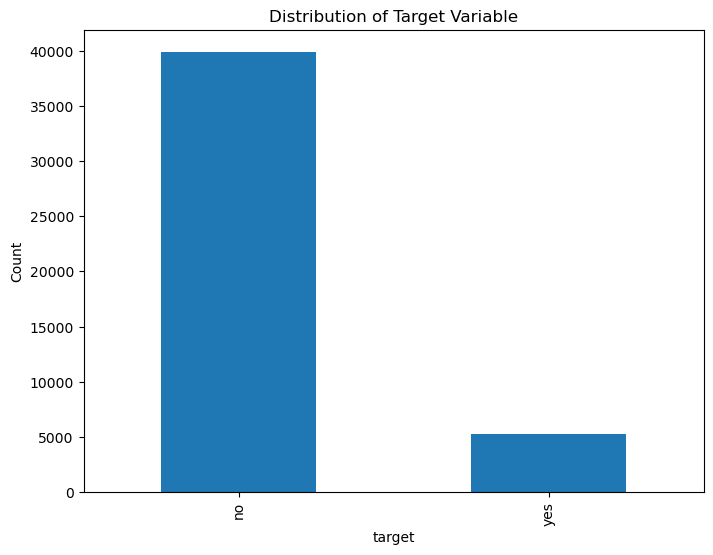

In [12]:
#Distribution plot of target variable
plt.figure(figsize=(8, 6))
data['target'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Variable')
plt.xlabel('target')
plt.ylabel('Count')
plt.show()



In [13]:
data.dtypes

age                int64
job               object
marital_status    object
education         object
credit_default    object
balance            int64
housing_loan      object
personal_loan     object
contact           object
day                int64
month             object
duration           int64
campaign           int64
pdays              int64
previous           int64
poutcome          object
target            object
dtype: object

In [ ]:
data['poutcome'].value_counts()

In [ ]:
##category distribution
data['job'].value_counts()/len(data)*100


In [ ]:
X=data.drop(columns=['y'])
y=data['y']
print(X.shape)
print(y.shape)

In [ ]:
data['y'].value_counts()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', SimpleImputer(strategy='most_frequent'), ['category'])
    ])

In [ ]:
# Convert labels to integers (0, 1, ...)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print(y_encoded)  # Output: [0 1 0]

In [ ]:
# Fill missing values with a placeholder (e.g., 'missing') before encoding
data_filled = data[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']].fillna('missing')

# Convert to one-hot encoded format
encoder = OneHotEncoder()
data_encoded = encoder.fit_transform(data_filled).toarray()


In [ ]:
# Convert the encoded data back to a DataFrame
data_encoded_df = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out(data_filled.columns))
# Concatenate the encoded data with the original DataFrame
data_encoded_df

In [ ]:
data_encoded_df.head

In [ ]:
data_encoded.view()

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,stratify=y,random_state=78)

In [ ]:
y_test.shape

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_test.info
